In [1]:
import os
import glob

import tdt
from functools import partial
import numpy as np
import matplotlib.pyplot as plt

from fptools.preprocess import trim_signals, detrend_double_exponential, estimate_motion, zscore_signals
from fptools.viz import plot_signal_at_events, plot_heatmap, collect_signals

In [ ]:
def preprocess(block, show_steps=True, cache=True):
    cache_path = os.path.join('cache', f'{block.info.blockname}.npz')
    if cache and os.path.exists(cache_path):
        print(f'loading cache: "{cache_path}"')
        with np.load(cache_path) as data:
            return data['time'], data['dopa'], data['isob']
    else:
        sampling_rate = block.streams['_465A'].fs
        dopa = block.streams['_465A'].data
        isob = block.streams['_415A'].data
        time = np.linspace(1,len(dopa), len(dopa)) / sampling_rate

        if show_steps:
            fig, axs = plt.subplots(6, 1, figsize=(24, 6*6))

            axs[0].plot(time, dopa, label='Dopamine', c='g')
            axs[0].plot(time, isob, label='Isosbestic', c='r')
            axs[0].set_title('Raw signal')
            axs[0].legend()

        # trim raw signal start to when the optical system came online
        dopa_trimmed, isob_trimmed, time_trimmed = trim_signals(dopa, isob, time, begin=int(block.scalars.Fi1i.ts[0] * sampling_rate))

        if show_steps:
            axs[1].plot(time_trimmed, dopa_trimmed, label='Dopamine', c='g')
            axs[1].plot(time_trimmed, isob_trimmed, label='Isosbestic', c='r')
            axs[1].set_title('Trimmed Raw signal')
            axs[1].legend()

        # detrend using a double exponential fit
        dopa_detrend, dopa_fit = detrend_double_exponential(time_trimmed, dopa_trimmed)
        isob_detrend, isob_fit = detrend_double_exponential(time_trimmed, isob_trimmed)

        if show_steps:
            axs[2].plot(time_trimmed, dopa_trimmed, label='Dopamine', c='g')
            axs[2].plot(time_trimmed, dopa_fit, label='Dbl Exp Fit', c='k')
            axs[2].plot(time_trimmed, isob_trimmed, label='Isosbestic', c='r')
            axs[2].plot(time_trimmed, isob_fit, label='Dbl Exp Fit', c='k')
            axs[2].set_title('Double Exponential Fit')
            axs[2].legend()

            axs[3].plot(time_trimmed, dopa_detrend, label='Dopamine', c='g')
            axs[3].plot(time_trimmed, isob_detrend, label='Isosbestic', c='r')
            axs[3].set_title('De-trended signals')
            axs[3].legend()

        # correct for motion artifacts
        dopa_motion_corrected, est_motion = estimate_motion(dopa_detrend, isob_detrend)

        if show_steps:
            axs[4].plot(time_trimmed, dopa_motion_corrected, label='Dopamine', c='g')
            axs[4].plot(time_trimmed, est_motion, label='Estimated Motion', c='b')
            axs[4].set_title('Motion Correction')
            axs[4].legend()

        #dopa, isob = zscore_signals(dopa, isob)
        # computed deltaF / F
        dopa_norm = 100 * dopa_motion_corrected / dopa_fit

        if show_steps:
            axs[5].plot(time_trimmed, dopa_norm, label='Dopamine', c='g')
            axs[5].set_title('Normalized')
            axs[5].legend()

        if cache:
            np.savez_compressed(cache_path, time=time_trimmed, dopa=dopa_norm, isob=isob_detrend)
            if show_steps:
                fig.savefig(cache_path.replace('.npz', '.png'), dpi=600)
                fig.savefig(cache_path.replace('.npz', '.pdf'))

        return time_trimmed, dopa_norm, isob_detrend

In [10]:
sessions = []
for p in glob.glob(r'M:\2024 July,Aug GRABDA2m data (DLS C1906Y)\Progressive Ratio tanks\PR day 1 *\*'):
    block = tdt.read_block(p)

    metadata = dict(block.info.items())
    dirname = os.path.basename(metadata['tankpath'])
    if 'Het' in dirname:
        metadata['genotype'] = 'Het'
    elif 'WT' in dirname:
        metadata['genotype'] = 'WT'
    else:
        raise RuntimeError('did not understand genotype')

    time, dopa, isob = preprocess(block, cache=True)

    sessions.append({
        'metadata': metadata,
        'signals': {
            'Time': time,
            'Dopamine': dopa,
            'Isosbestic': isob,
        },
        'events': {k: block.epocs[k].onset for k in block.epocs.keys()}
    })

print(sessions)


read from t=0s to t=3599.1s
loading cache: "cache\EN140_PRD1-240813-133324.npz"
read from t=0s to t=3599.2s
loading cache: "cache\EN166_PRD1-240813-144634.npz"
read from t=0s to t=3599.09s
loading cache: "cache\EN171_PRD1-240815-144154.npz"
read from t=0s to t=3599.1s
loading cache: "cache\EN173_PRD1-240813-131545.npz"
read from t=0s to t=3599.23s
loading cache: "cache\EN181_PRD1-240813-113424.npz"
read from t=0s to t=3599.39s
loading cache: "cache\EN182_PRD1-240812-113817.npz"
read from t=0s to t=3599.1s
loading cache: "cache\EN183_PRD1-240813-142446.npz"
read from t=0s to t=3599.19s
loading cache: "cache\EN189_PRD1-240813-115007.npz"
read from t=0s to t=3599.08s
loading cache: "cache\ym61_PRD1-240819-133125.npz"
read from t=0s to t=3599.21s
loading cache: "cache\EN145_PRD1-240819-144327.npz"
read from t=0s to t=3599.2s
loading cache: "cache\EN147_PRD1-240811-124748.npz"
read from t=0s to t=3599.2s
loading cache: "cache\EN157_PRD1-240814-125543.npz"
read from t=0s to t=3599.08s
loadin

In [11]:
for session in sessions:
    session['event_aligned'] = {}
    session['event_aligned']['Dopamine@RNP'] = {}
    session['event_aligned']['Dopamine@RNP']['time'], session['event_aligned']['Dopamine@RNP']['signal'] = collect_signals(session['events']['RNP_'], session['signals']['Dopamine'], session['signals']['Time'], pre=3, post=5)

In [5]:
session['signals']['Dopamine']

array([-2.92437239, -2.93561935, -2.94757659, ...,  6.11503919,
        6.10089764,  6.08604691])

In [13]:
time = sessions[0]['event_aligned']['Dopamine@RNP']['time']
all_rnp_sigs = np.vstack([session['event_aligned']['Dopamine@RNP']['signal'] for session in sessions])
wt_rnp_sigs = np.vstack([session['event_aligned']['Dopamine@RNP']['signal'] for session in sessions if session['metadata']['genotype'] == 'WT'])
het_rnp_sigs = np.vstack([session['event_aligned']['Dopamine@RNP']['signal'] for session in sessions if session['metadata']['genotype'] == 'Het'])
session_labels = np.hstack([[i] * session['event_aligned']['Dopamine@RNP']['signal'].shape[0] for i, session in enumerate(sessions)])

print(time.shape, all_rnp_sigs.shape, session_labels.shape)

(8138,) (339, 8138) (339,)


Text(0.5, 23.52222222222222, 'Time, Reletive to Event (sec)')

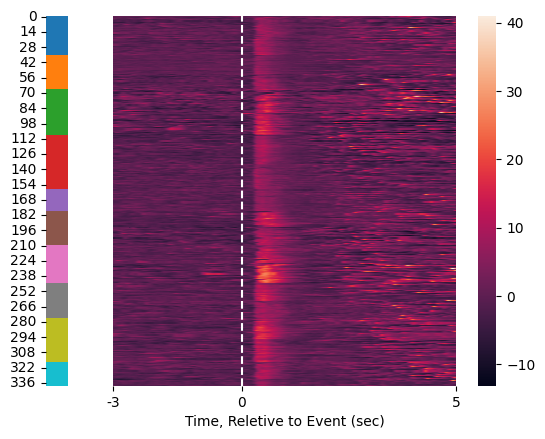

In [19]:
from fptools.viz import find_nearest
import seaborn as sns

fig, axs = plt.subplots(1, 2, width_ratios=(1, 20))

sns.heatmap(data=session_labels[:, None], cmap='tab10', ax=axs[0], cbar=False)
axs[0].set_xticks([])

sns.heatmap(data=all_rnp_sigs, ax=axs[1], cmap=None)
axs[1].axvline(find_nearest(time, 0), c='w', ls='--')

ticks = []
ticklabels = []
for t in [-3, 0, 5]:
    ticks.append(find_nearest(time, t))
    ticklabels.append(f'{t:0.0f}')
axs[1].set_xticks(ticks, labels=ticklabels, rotation=0)
axs[1].set_yticks([])
axs[1].set_xlabel('Time, Reletive to Event (sec)')

Text(0.5, 0, 'Time, Reletive to Event (s)')

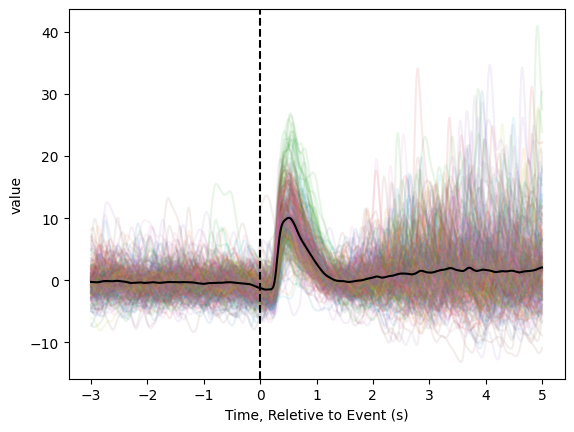

In [9]:
import pandas as pd

df = pd.DataFrame(all_rnp_sigs.T)
df.index = time
df = df.melt(ignore_index=False)

fig, ax = plt.subplots()

indv_colors = sns.color_palette('tab10', np.unique(session_labels).shape[0])


for i in range(all_rnp_sigs.shape[0]):
    sns.lineplot(data=None, x=time, y=all_rnp_sigs[i, :], alpha=0.1, ax=ax, color=indv_colors[session_labels[i]])

sns.lineplot(data=df, x=df.index, y='value', ax=ax, color='k')
ax.axvline(0, c='k', ls='--')
ax.set_xlabel('Time, Reletive to Event (s)')

Text(0.5, 0, 'Time, Reletive to Event (s)')

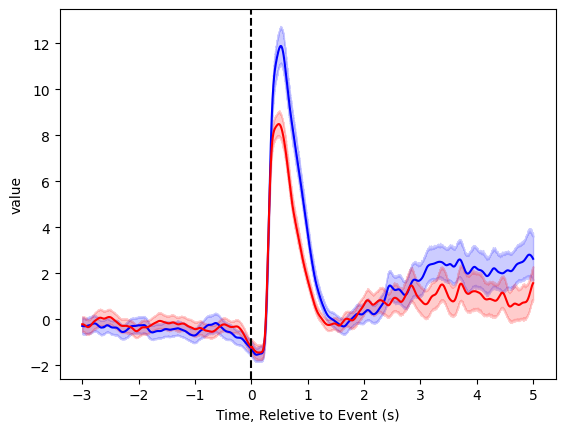

In [16]:
import pandas as pd

wt_df = pd.DataFrame(wt_rnp_sigs.T)
wt_df.index = time
wt_df = wt_df.melt(ignore_index=False)

het_df = pd.DataFrame(het_rnp_sigs.T)
het_df.index = time
het_df = het_df.melt(ignore_index=False)

fig, ax = plt.subplots()




sns.lineplot(data=wt_df, x=wt_df.index, y='value', ax=ax, color='b')
sns.lineplot(data=het_df, x=het_df.index, y='value', ax=ax, color='r')
ax.axvline(0, c='k', ls='--')
ax.set_xlabel('Time, Reletive to Event (s)')

In [17]:
for session in sessions:
    print(session['event_aligned']['Dopamine@RNP']['signal'].shape)

(19, 8138)
(17, 8138)
(17, 8138)
(14, 8138)
(22, 8138)
(20, 8138)
(27, 8138)
(23, 8138)
(20, 8138)
(14, 8138)
(17, 8138)
(16, 8138)
(19, 8138)
(16, 8138)
(16, 8138)
(19, 8138)
(21, 8138)
(16, 8138)
(6, 8138)


Text(0.5, 1.0, 'last 5 RNPs')

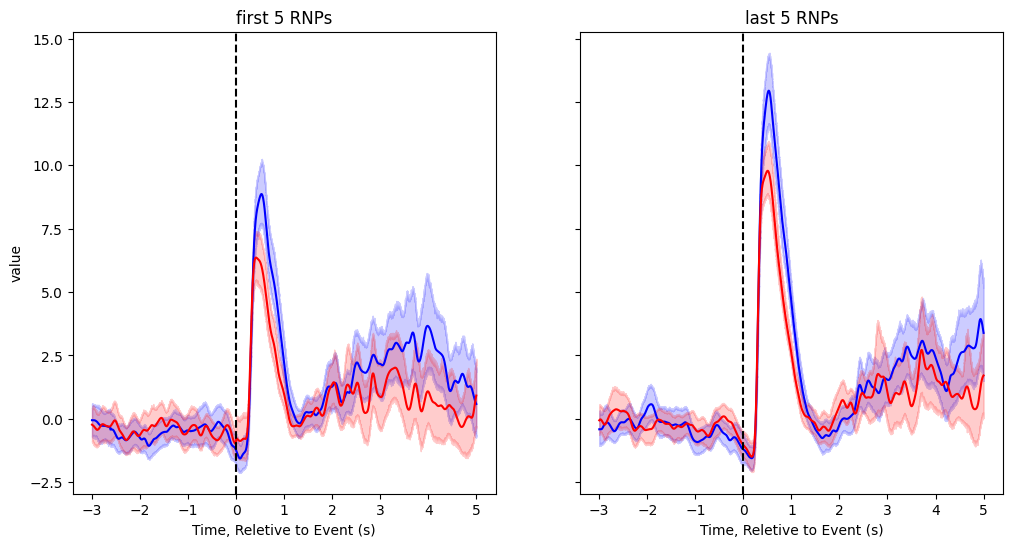

In [18]:
time = sessions[0]['event_aligned']['Dopamine@RNP']['time']

wt_rnp_sigs_first = np.vstack([session['event_aligned']['Dopamine@RNP']['signal'][0:5] for session in sessions if session['metadata']['genotype'] == 'WT'])
het_rnp_sigs_first = np.vstack([session['event_aligned']['Dopamine@RNP']['signal'][0:5] for session in sessions if session['metadata']['genotype'] == 'Het'])

wt_rnp_sigs_last = np.vstack([session['event_aligned']['Dopamine@RNP']['signal'][-5:] for session in sessions if session['metadata']['genotype'] == 'WT'])
het_rnp_sigs_last = np.vstack([session['event_aligned']['Dopamine@RNP']['signal'][-5:] for session in sessions if session['metadata']['genotype'] == 'Het'])


wt_df_first = pd.DataFrame(wt_rnp_sigs_first.T)
wt_df_first.index = time
wt_df_first = wt_df_first.melt(ignore_index=False)

wt_df_last = pd.DataFrame(wt_rnp_sigs_last.T)
wt_df_last.index = time
wt_df_last = wt_df_last.melt(ignore_index=False)

het_df_first = pd.DataFrame(het_rnp_sigs_first.T)
het_df_first.index = time
het_df_first = het_df_first.melt(ignore_index=False)

het_df_last = pd.DataFrame(het_rnp_sigs_last.T)
het_df_last.index = time
het_df_last = het_df_last.melt(ignore_index=False)

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

sns.lineplot(data=wt_df_first, x=wt_df_first.index, y='value', ax=axs[0], color='b')
sns.lineplot(data=het_df_first, x=het_df_first.index, y='value', ax=axs[0], color='r')
axs[0].axvline(0, c='k', ls='--')
axs[0].set_xlabel('Time, Reletive to Event (s)')
axs[0].set_title('first 5 RNPs')


sns.lineplot(data=wt_df_last, x=wt_df_last.index, y='value', ax=axs[1], color='b')
sns.lineplot(data=het_df_last, x=het_df_last.index, y='value', ax=axs[1], color='r')
axs[1].axvline(0, c='k', ls='--')
axs[1].set_xlabel('Time, Reletive to Event (s)')
axs[1].set_title('last 5 RNPs')
